# Лабораторная работа №3

## Условие

Вариант №9

Файл с данными: `data_lab3v04.csv`.

Число нейронов 1-го скрытого слоя: `20`.

Активационная характеристика нейронов 1-го скрытого слоя: `logistic`.

Число нейронов 2-го скрытого слоя: `20`.

Активационная характеристика нейронов 2-го скрытого слоя: `logistic`.

Режим обучения: `Minibatch, batchsize = 20`.

## Настройка среды разработки

### Правильное отображение tqdm.notebook при темной теме в VS Code

In [29]:
from IPython.display import display, HTML

display(HTML("""
<style>
    .cell-output-ipywidget-background {
        background-color: transparent !important;
    }

    :root {
        --jp-widgets-color: var(--vscode-editor-foreground);
        --jp-widgets-font-size: var(--vscode-editor-font-size);
    }
</style>
"""))


## Импорты

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.colors import ListedColormap
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from time import time
from tqdm.auto import tqdm
from torchview import draw_graph  # рендер схемы нейронной сети

## Определения

In [31]:
plt.style.use("seaborn-v0_8")

torch.random.manual_seed(int(time()))
np.random.seed(int(time()))

In [32]:
n_neurons1 = 20

act1 = nn.Sigmoid()

n_neurons2 = 20

act2 = nn.Sigmoid()

batch_size = 20

In [33]:
df = pd.read_csv("data.csv", names=["$x_1$", "$x_2$", "$y_{true}$"])
df.head()

,$x_1$,$x_2$,$y_{true}$
0,1.4703,1.45800,1
1,5.3021,0.98959,1
2,3.8676,1.84660,1
3,3.3552,3.24970,1
4,-1.8971,2.05400,1


## 1. Исходные данные

### Разведочный анализ

In [34]:
print("Число признаков:", df.shape[1] - 1)
print("Число классов:", df.iloc[:, -1].nunique())
print("Объем выборки:", len(df))
print("Объемы выборок для каждого класса:", df.iloc[:, -1].value_counts().to_list())

Число признаков: 2
Число классов: 4
Объем выборки: 600
Объемы выборок для каждого класса: [200, 150, 150, 100]


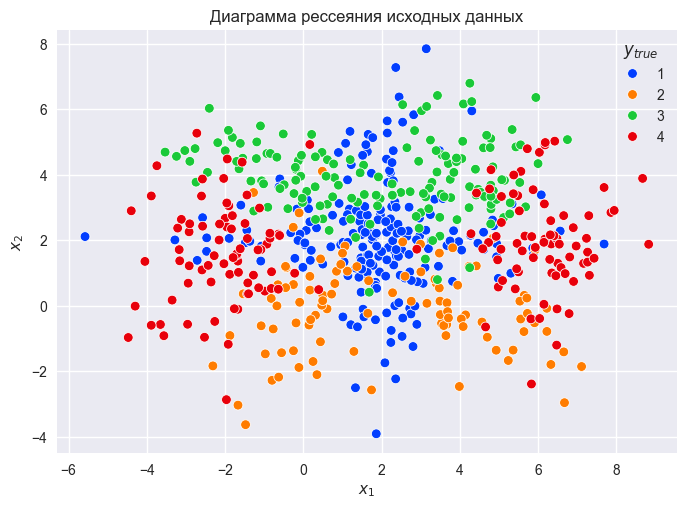

In [35]:
sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], 
                hue=df.columns[2], palette="bright")
plt.title("Диаграмма рессеяния исходных данных")
plt.show()

### Формирование обучающей, валидационной и тестовой выборок

In [36]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy() - df.iloc[:, -1].min() #Всегда удобнее лэйблы от 0 до K - 1, где K - количество классов 

X[:5], y[:5]

(array([[ 1.4703 ,  1.458  ],
        [ 5.3021 ,  0.98959],
        [ 3.8676 ,  1.8466 ],
        [ 3.3552 ,  3.2497 ],
        [-1.8971 ,  2.054  ]]),
 array([0, 0, 0, 0, 0]))

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=2/3, random_state=42)

y_train_counts = np.unique_counts(y_train).counts.tolist()
y_test_counts = np.unique_counts(y_test).counts.tolist()
y_val_counts = np.unique_counts(y_val).counts.tolist()
y_total_counts = np.unique_counts(y).counts.tolist()

print(f"Объем выборки: {len(x_train)=}, {len(x_val)=}, {len(x_test)=}, total={len(X)}")
print(f"Объемы выборок для каждого класса: {y_train_counts=}, {y_test_counts=}, {y_val_counts=}, {y_total_counts=}")

Объем выборки: len(x_train)=360, len(x_val)=180, len(x_test)=60, total=600
Объемы выборок для каждого класса: y_train_counts=[112, 69, 84, 95], y_test_counts=[27, 8, 8, 17], y_val_counts=[61, 23, 58, 38], y_total_counts=[200, 100, 150, 150]


### Предобработка данных

#### Предобработка входов

In [38]:
class Whiter():
    def __init__(self):
        self.fit_flag = False

    def fit(self, X):
        # 1. Центрирование
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # 2. Ковариационная матрица
        cov = np.cov(X_centered, rowvar=False)
        
        # 3. Вычисление матрицы преобразования
        self.W = sqrtm(np.linalg.inv(cov))
        self.fit_flag = True

    def transform(self, X):
        if not self.fit_flag:
            raise Exception("Whitening matrix is not initialized")
        
        X_centered = X - self.mean

        X_white = X_centered @ self.W
        
        return X_white

    def fit_transform(self, X):
        self.fit(X)
        X_white = self.transform(X)

        return X_white

    def inverse_transform(self, X_white):
        if not self.fit_flag:
            raise Exception("Whitening matrix is not initialized")
        return (X_white @ np.linalg.inv(self.W)) + self.mean

In [39]:
x_whiter = Whiter()

x_train_white = x_whiter.fit_transform(x_train)
x_val_white = x_whiter.transform(x_val)
x_test_white = x_whiter.transform(x_test)

x_train_white_tensor = torch.FloatTensor(x_train_white)
x_val_white_tensor = torch.FloatTensor(x_val_white)
x_test_white_tensor = torch.FloatTensor(x_test_white)

x_train_white_tensor.shape, torch.cov(x_train_white_tensor.transpose(0, 1))

(torch.Size([360, 2]),
 tensor([[ 1.0000e+00, -7.9694e-09],
         [-7.9694e-09,  1.0000e+00]]))

#### Предобработка выходов

Функция потерь `torch.nn.CrossEntropyLoss()` принимает на вход выход нейронной сети в виде виде обычного массива чисел без наложения условий на эти числа. Размер массива должен быть такой же, как и число классов. На последний слой нет смысла навешивать `SoftMax`, так как `torch` под капотом считает его в этой функции потерь.

Что касается истинных значений, то можно подавать как `labels` (одно число для каждого примера), так и `one_hot_encoded` (засовывая вектора как вероятности). Поэтому было принято решение не предобрабатывать `y_true` в датасете с помощью `OneHotEncoder`, так как это излишне. Гораздо лучше перевести метки классов в числа от 0 до 3, а не от 1 до 4, как в сырых данных.

Ниже представлен пример ячейки, что без разницы как засовывать игреки.

Но, если бы мы делали это руками, то конечно делали бы предобработку в виде вышеупомянутых `OneHotEncoding` и `SoftMax`, поэтому в отчёте я так и напишу, что всё это проделано, хоть и неявно.

In [40]:
y_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

y_train_one_hot = y_ohe.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = y_ohe.transform(y_val.reshape(-1, 1))
y_test_one_hot = y_ohe.transform(y_test.reshape(-1, 1))

print("Закодированные выходы:", y_train_one_hot[:5], y_val_one_hot[:5], y_test_one_hot[:5], sep="\n")

test_output = (std := 4) * torch.randn(360, 4) - (mean := 1)
loss = nn.CrossEntropyLoss()(test_output, torch.LongTensor(y_train))
loss2 = nn.CrossEntropyLoss()(test_output, torch.FloatTensor(y_train_one_hot))
print(f"Как видно, числа получаются одинаковые: {loss.item()=:.4f}, {loss2.item()=:.4f}")

Закодированные выходы:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
Как видно, числа получаются одинаковые: loss.item()=4.2606, loss2.item()=4.2606


Получили на выходе одно и то же, однако первый способ эффективнее с точки зрения вычислений.

In [41]:
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

#### Формирование датасетов и даталоадеров

In [42]:
train_dataset = torch.utils.data.TensorDataset(x_train_white_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_white_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_white_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(val_dataset))

## 2. Построение нейросетевого классификатора с двумя скрытыми слоями

### 2.1. Архитектура и схема нейронной сети

In [43]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(df.shape[1] - 1, n_neurons1)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        nn.init.normal_(self.fc1.bias, mean=0.0, std=0.1)
        self.act1 = act1

        self.fc2 = nn.Linear(n_neurons1, n_neurons2)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0.0, std=0.1)
        self.act2 = act2

        self.fc3 = nn.Linear(n_neurons2, len(np.unique(y)))
        torch.nn.init.xavier_normal_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0.0, std=0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [44]:
# схема нейронной сети
graph = draw_graph(Classifier(), input_data=torch.zeros(size=(1, 2)))
graph.visual_graph.render(
    filename="one_hid_scheme", directory="img", view=False, format="png"
)

'img/one_hid_scheme.png'

### 2.2. Обучение нейронной сети

#### 2.2.1. Определение функций обучения и валидации

Я выбрал критерий останова `ранний останов`. Этот метод заключается в том, чтобы остановить обучение тогда, когда на валидационных данных функция потерь начнет закономерно расти (например, `patience=10` раз подряд). Тогда останавливаемся, откатываем веса обратно и считаем, что сеть обучена.

In [45]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.stopping_flag = False
        self.patience = patience
        self.best_loss = float("inf")
        self.trigger_times = 0

    def __call__(self, current_loss):
        # ошибка уменьшилась - сбрасываем счетчик
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.trigger_times = 0
            return 0

        # ошибка как минимум на том же уровне - увеличиваем счетчик и, если patience превышен, совершаем останов
        else:
            self.trigger_times += 1
            if self.trigger_times < self.patience:
                return 1
            else:
                self.stopping_flag = True
                return 2

Нужно правильно подсчитывать функцию потерь, чтобы в будущем корректно ее визуализировать.

Пусть наша выборка $\{(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)\}$ разбита на батчи $B = \{b_1, b_2, \ldots, b_K\}$, где $K$ - число батчей, $b_k = \{(x_{k_1}, y_{k_1}), (x_{k_2}, y_{k_2}), \ldots, (x_{k_{N_k}}, y_{k_{N_k}})\}$ - батч, состоящий из $N_k$ примеров. 

Тогда функция потерь для $k$-ого батча $E_k(w)$ вычисляется по формуле:

$$ E_k(w) = \dfrac{1}{N_k} \sum\limits_{i = 1}^{N_k} L(y_{k_i}, F(x_{k_i}, w)) $$

А общая функция потерь для всей выборки $E(w)$ (то есть функция потерь для эпохи) вычисляется по формуле:

$$ E(w) = \dfrac{\sum\limits_{k = 1}^{K} N_k \cdot E_k(w)}{\sum\limits_{k = 1}^{K} N_k} = \dfrac{1}{n}\sum\limits_{k = 1}^{K} N_k \cdot E_k(w)$$

Мы применяем взвешенное среднее, чтобы учесть разные размеры батчей (обычно последний батч меньше остальных), поэтому функция потерь не будет зависеть от размера каждого батча, при этом градиент будет вычисляться от каждого E_k(w) и тоже не будет зависеть от размера батча.

In [46]:
def evaluate(model, loader, criterion):
    accum_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            accum_loss += len(x_batch) * loss.item()
            y_pred_labels = y_pred.argmax(1)
            correct += y_pred_labels.eq(y_batch).sum().item()
            total += len(y_batch)
    
    total_loss = accum_loss / len(loader.dataset)
    accuracy = correct / total

    return total_loss, accuracy

In [47]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    accum_loss = 0
    correct = 0
    total = 0
    model.train()
    for x_batch, y_batch in (p_bar := tqdm(train_loader, desc=f"Батчи", leave=False, unit="батч")):
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        accum_loss += len(x_batch) * loss.item()
        y_pred_labels = y_pred.argmax(1)
        correct += y_pred_labels.eq(y_batch).sum().item()
        total += len(y_batch)

    epoch_loss = accum_loss / len(train_loader.dataset)
    accuracy = correct / total

    return epoch_loss, accuracy

In [48]:
def train(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    max_epochs,
    patience,
):
    stopping = EarlyStopping(patience=patience)
    history_rows = []
    

    # записываем начальные параметры модели
    best_model = {
        name: param.clone().detach()  # клонируем и отключаем граф вычислений
        for name, param in model.state_dict().items()
    }

    for epoch in (p_bar := tqdm(range(max_epochs), desc="Обучение", unit="эпоха")):
        # записываем различные потери по ходу обучения
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)

        epoch_dict = {
            r"$\tau$": epoch + 1,

            r"$E_{train}(\tau)$": train_loss,
            r"$\varepsilon_{train}(\tau)$": 1 - train_accuracy,
            r"$E_{val}(\tau)$": val_loss,
            r"$\varepsilon_{val}(\tau)$": 1 - val_accuracy,
            r"$E_{test}(\tau)$": test_loss,
            r"$\varepsilon_{test}(\tau)$": 1 - test_accuracy,
        }
        history_rows.append(epoch_dict)
        p_bar.set_postfix({"E_tr": round(train_loss, 2), "acc_tr": round(train_accuracy, 2),
                           "E_val": round(val_loss, 2), "acc_val": round(val_accuracy, 2)})

        stopping_signal = stopping(val_loss)
        if stopping_signal == 2:
            print(f"Early stopping at epoch {epoch}")
            break
        elif stopping_signal == 0:
            best_model = {
                name: param.clone().detach()  # клонируем и отключаем граф вычислений
                for name, param in model.state_dict().items()
            }

    # восстанавливаем лучшие параметры у модели
    model.load_state_dict(best_model)

    # откатываем оценки в момент, когда параметры модели были лучшими
    history_rows = history_rows[:-stopping.trigger_times]

    result = pd.DataFrame(history_rows).set_index(r"$\tau$")

    return model, result

#### 2.2.2 Обучение нейронной сети

In [49]:
model = Classifier()
learning_rate = 0.5e-1
momentum = 0.9
max_epochs = 10000
patience = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

model, result = train(
    model, train_loader, val_loader, test_loader, 
    criterion, optimizer, max_epochs, patience)

Обучение:   0%|          | 0/10000 [00:00<?, ?эпоха/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Early stopping at epoch 354


#### 2.2.3. Оценивание качества обучения

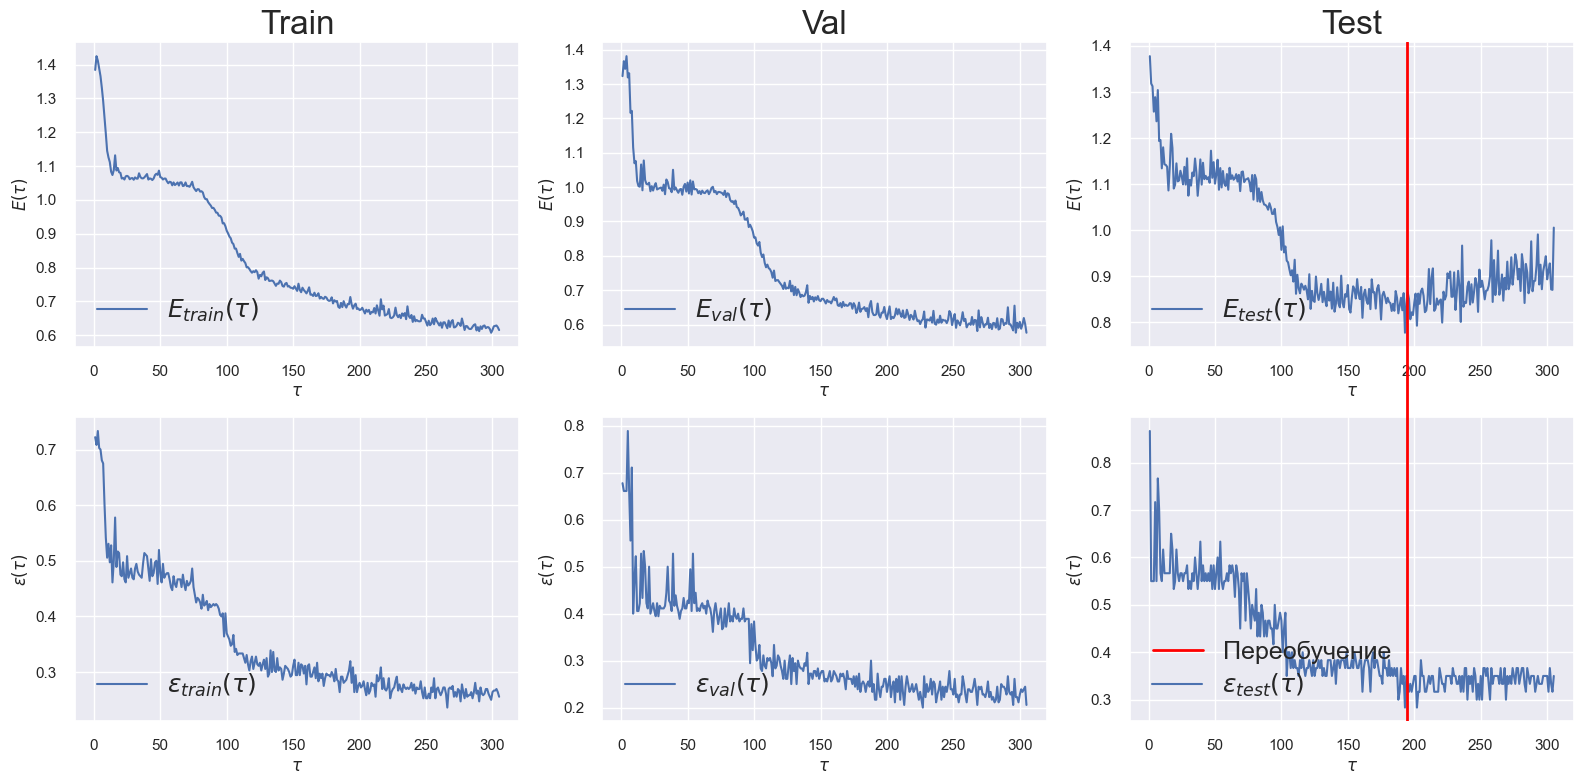

In [57]:
plt.figure(figsize=(16, 8))
columns = [col for col in result.columns if col.startswith(r"$E_")]
for i, col in enumerate(columns, start=1):
    plt.subplot(2, 3, i)
    plt.plot(result.index, result[col], label=col)
    plt.xlabel(result.index.name)
    plt.ylabel(r"$E(\tau)$")
    plt.legend(fontsize=18, loc="lower left")
    plt.title(col[4].upper() + col[5:-8], fontsize=24)

columns = [col for col in result.columns if col.startswith(r"$\varepsilon_")]
for i, col in enumerate(columns, start=4):
    plt.subplot(2, 3, i)
    plt.plot(result.index, result[col], label=col)
    plt.xlabel(result.index.name)
    plt.ylabel(r"$\varepsilon(\tau)$")
    plt.legend(fontsize=18, loc="lower left")

# Начало переобучения

x_position = 190
line_color = 'red'
line_width = 2

plt.subplot(1, 3, 3)
plt.axvline(x=x_position, color=line_color, linewidth=line_width, label="Переобучение")
plt.xlim(-10, 310)
plt.legend(fontsize=18, loc=(0.03, 0.07))

ax = plt.gca()  # Получить текущие оси
ax.axis('off')  # Выключить отображение осей

plt.tight_layout()
plt.show()

In [51]:
columns = [col for col in result.columns if col.startswith(r"$E_")]
print(result.loc[:, columns].mean())

columns = [col for col in result.columns if col.startswith(r"$\varepsilon_")]
print(result.loc[:, columns].iloc[-1])

$E_{train}(\tau)$    0.818221
$E_{val}(\tau)$      0.767661
$E_{test}(\tau)$     0.953401
dtype: float64
$\varepsilon_{train}(\tau)$    0.255556
$\varepsilon_{val}(\tau)$      0.205556
$\varepsilon_{test}(\tau)$     0.350000
Name: 305, dtype: float64


In [52]:
with torch.no_grad():
    y_pred_train = model(x_train_white_tensor).argmax(1)
    y_pred_test = model(x_test_white_tensor).argmax(1)

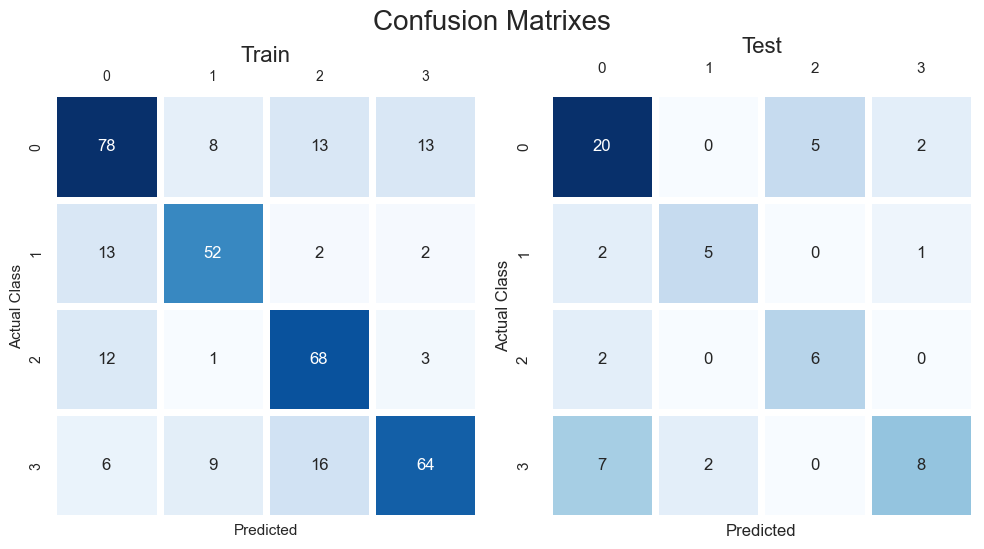

In [53]:
fig = plt.figure(figsize=(10, 5.5))
fig.suptitle("Confusion Matrixes", fontsize=20)

plt.subplot(121)
sns.set_theme(font_scale=1.0)
cm = confusion_matrix(y_train_tensor, y_pred_train)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,square=True, linewidths=5)
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='both', top=False)
plt.xlabel('Predicted')
plt.ylabel('Actual Class')
plt.title('Train', fontsize=16)

plt.subplot(122)
cm = confusion_matrix(y_test_tensor, y_pred_test)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,square=True, linewidths=5)
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='both', top=False)
plt.xlabel('Predicted')
plt.ylabel('Actual Class')
plt.title('Test', fontsize=16)

plt.tight_layout()
plt.show()

In [61]:
def rgb(r, g, b):
    return (r/255, g/255, b/255)

def paint_classes(model, x, y, labels):
    plt.figure(figsize=(10, 8))

    eps = 0.1
    xx, yy = np.meshgrid(np.linspace(x.min() - eps, x.max() + eps, 400),
                        np.linspace(y.min() - eps, y.max() + eps, 400))

    mesh_coordinates = np.c_[xx.ravel(), yy.ravel()]

    with torch.no_grad():
        Z = model(torch.FloatTensor(x_whiter.transform(mesh_coordinates))).argmax(1).reshape(xx.shape) + 1

    cmap_light = ListedColormap([rgb(161, 201, 244), rgb(255, 180, 130), rgb(139, 226, 159), rgb(251, 156, 152)])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    sns.scatterplot(x=x, y=y, 
                    hue=labels, palette="bright")

    plt.title("Формируемые обученной сетью области классов")
    
    plt.show()

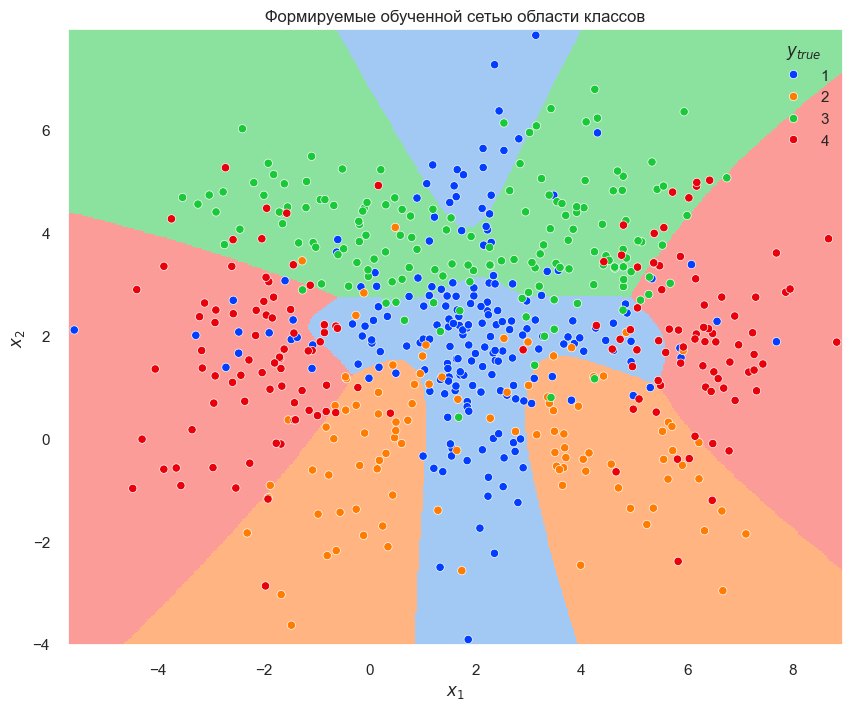

In [62]:
paint_classes(model, df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2])

## 3. Проверка устойчивости найденного решения.

Обучение:   0%|          | 0/10000 [00:00<?, ?эпоха/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Батчи:   0%|          | 0/18 [00:00<?, ?батч/s]

Early stopping at epoch 383
$E_{train}(\tau)$    0.791172
$E_{val}(\tau)$      0.731257
$E_{test}(\tau)$     0.909743
dtype: float64
$\varepsilon_{train}(\tau)$    0.269444
$\varepsilon_{val}(\tau)$      0.250000
$\varepsilon_{test}(\tau)$     0.350000
Name: 334, dtype: float64


/Users/retrobanner/WorkBench/Neural_Networks/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


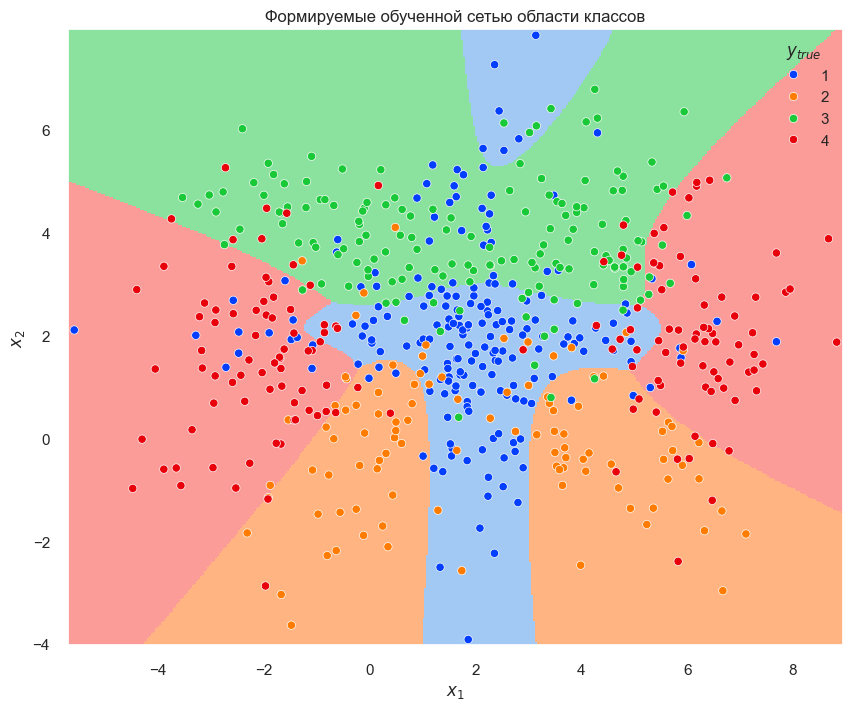

In [ ]:
model2 = Classifier()
optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate, momentum=momentum)

model2, result2 = train(
    model2, train_loader, val_loader, test_loader, 
    criterion, optimizer2, max_epochs, patience)

columns = [col for col in result2.columns if col.startswith(r"$E_")]
print(result2.loc[:, columns].mean())

columns = [col for col in result2.columns if col.startswith(r"$\varepsilon_")]
print(result2.loc[:, columns].iloc[-1])


paint_classes(model2, df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2])